In [1]:
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [3]:
# Fetch data
ticker = '^NSEI'
df = yf.download(ticker, start='2024-01-01', end='2025-01-01')
df = df.asfreq('B')  # Set frequency to business days ('B')
data = df['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
data.dropna(inplace=True)
data

/var/folders/b9/966lwbmx12gd_1zc07v_3kvr0000gn/T/ipykernel_47292/731352529.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Ticker,^NSEI
Date,
2024-01-01,21741.900391
2024-01-02,21665.800781
2024-01-03,21517.349609
2024-01-04,21658.599609
2024-01-05,21710.800781
...,...
2024-12-24,23727.650391
2024-12-26,23750.199219
2024-12-27,23813.400391


In [7]:
def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print("Data is non-stationary. Consider differencing.")
    else:
        print("Data is stationary.")
        
        
print("Initial stationarity check:")
check_stationarity(data)

Initial stationarity check:
ADF Statistic: -1.5406608797686048
p-value: 0.5133097511793091
Data is non-stationary. Consider differencing.


In [9]:
diff_data = data.diff().dropna()
diff_data.head()

print("\nStationarity check after differencing:")
check_stationarity(diff_data)


Stationarity check after differencing:
ADF Statistic: -18.276143273482077
p-value: 2.313795225175018e-30
Data is stationary.


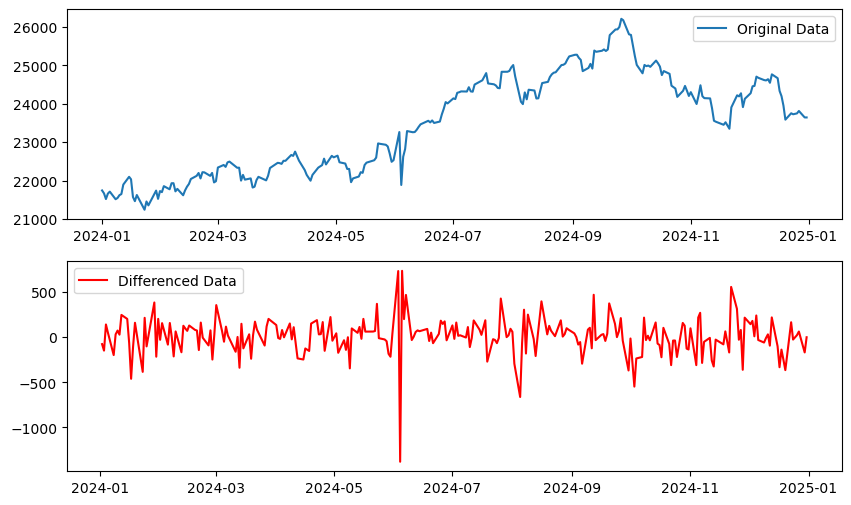

In [11]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(data, label='Original Data')
plt.legend()
plt.subplot(2,1,2)
plt.plot(diff_data, label='Differenced Data', color='red')
plt.legend()
plt.show()

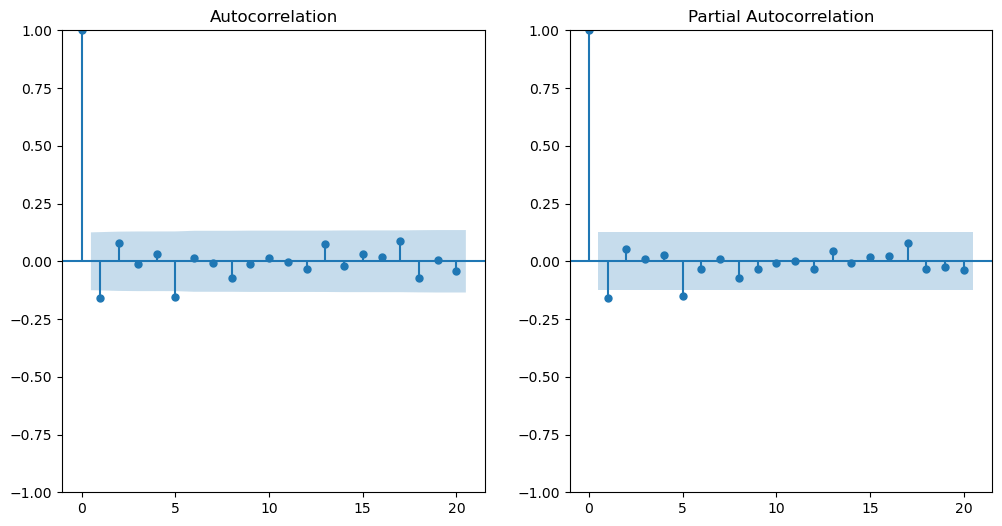

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(diff_data, lags=20, ax=plt.gca())
plt.subplot(122)
plot_pacf(diff_data, lags=20, ax=plt.gca())
plt.show()

APPROACH 1

In [16]:
# Split data into training and validation sets
train_size = int(len(data) * 0.8)
train, validation = data[:train_size], data[train_size:]

In [18]:
p_range = range(0, 8)
d_range = range(1, 2)
q_range = range(0, 8)

In [20]:
best_rmse = float("inf")
best_order = None
best_model = None

In [22]:
from sklearn.metrics import mean_squared_error
from itertools import product
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

for p, d, q in product(p_range, d_range, q_range):
    try:
        # Fit the ARIMA model
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        
        # Forecast on validation set
        forecast = model_fit.forecast(steps=len(validation))
        
        # Calculate RMSE for the forecast
        rmse = np.sqrt(mean_squared_error(validation, forecast))
        print(f'Order: {(p, d, q)}, RMSE: {rmse}')
        
        # Update best model if RMSE is lower
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = (p, d, q)
            best_model = model_fit

    except Exception as e:
        print(f'Failed to fit ARIMA({p}, {d}, {q}): {e}')
        
print(f'Best (p, d, q) order: {best_order}, RMSE: {best_rmse}')

Order: (0, 1, 0), RMSE: 696.132705073678
Order: (0, 1, 1), RMSE: 730.3882967561185
Order: (0, 1, 2), RMSE: 711.0315551675692
Order: (0, 1, 3), RMSE: 710.9171181683796
Order: (0, 1, 4), RMSE: 707.967883828862
Order: (0, 1, 5), RMSE: 758.3413028080664
Order: (0, 1, 6), RMSE: 763.9067620187321
Order: (0, 1, 7), RMSE: 773.9934976991815
Order: (1, 1, 0), RMSE: 725.6460863855401
Order: (1, 1, 1), RMSE: 714.710160826743
Order: (1, 1, 2), RMSE: 724.1072473081215
Order: (1, 1, 3), RMSE: 723.4264426295682
Order: (1, 1, 4), RMSE: 700.7798028752735
Order: (1, 1, 5), RMSE: 773.9863682007453
Order: (1, 1, 6), RMSE: 781.7854814076255
Order: (1, 1, 7), RMSE: 784.284225602481
Order: (2, 1, 0), RMSE: 716.0051277593516
Order: (2, 1, 1), RMSE: 722.074803342901
Order: (2, 1, 2), RMSE: 779.1480087584906
Order: (2, 1, 3), RMSE: 776.9768121810517
Order: (2, 1, 4), RMSE: 779.2257546230851
Order: (2, 1, 5), RMSE: 782.4903700540052
Order: (2, 1, 6), RMSE: 782.6499578434334
Order: (2, 1, 7), RMSE: 755.50440765436

In [24]:
forecast_steps = 20

future_dates = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='B')[1:]

# future_predictions = best_model.forecast(steps=forecast_steps)
future_predictions = best_model.predict(start=len(data), end=len(data) + forecast_steps - 1)

In [26]:
future_dates

DatetimeIndex(['2025-01-01', '2025-01-02', '2025-01-03', '2025-01-06',
               '2025-01-07', '2025-01-08', '2025-01-09', '2025-01-10',
               '2025-01-13', '2025-01-14', '2025-01-15', '2025-01-16',
               '2025-01-17', '2025-01-20', '2025-01-21', '2025-01-22',
               '2025-01-23', '2025-01-24', '2025-01-27', '2025-01-28'],
              dtype='datetime64[ns]', freq='B')

In [28]:
future_predictions

246    24659.034287
247    24597.193777
248    24622.195802
249    24654.890857
250    24590.260839
251    24586.571582
252    24632.534213
253    24580.558409
254    24552.858052
255    24607.136378
256    24579.877851
257    24535.703243
258    24589.891061
259    24592.628058
260    24539.937088
261    24583.447944
262    24613.819830
263    24560.239095
264    24583.120727
265    24632.991753
Name: predicted_mean, dtype: float64

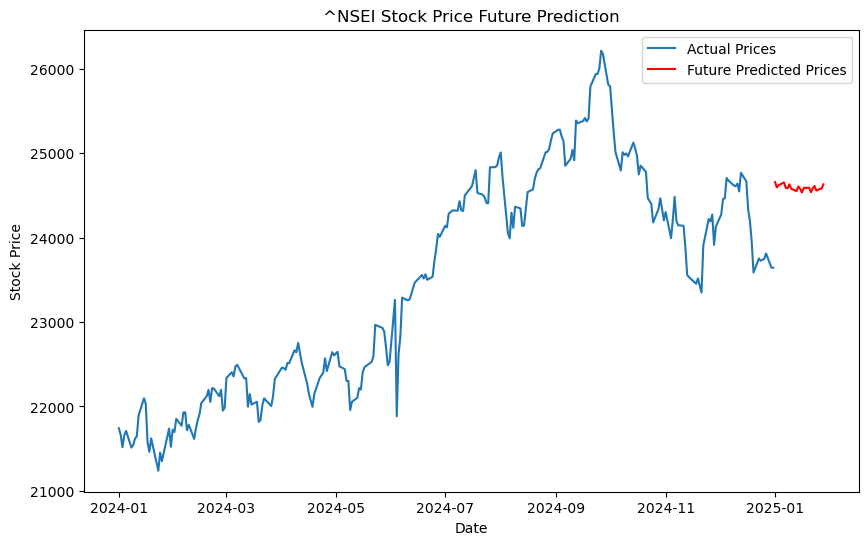

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data, label='Actual Prices')
future_dates = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='B')[1:]
plt.plot(future_dates, future_predictions, label='Future Predicted Prices', color='red')
plt.title(f'{ticker} Stock Price Future Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

forecasted_values = np.array(future_predictions) # forecasted values from ARIMA Model
forecasted_values

array([24659.03428664, 24597.19377692, 24622.19580181, 24654.89085706,
       24590.260839  , 24586.57158228, 24632.5342125 , 24580.55840878,
       24552.85805174, 24607.13637772, 24579.87785062, 24535.70324267,
       24589.89106134, 24592.62805806, 24539.93708763, 24583.44794404,
       24613.81983006, 24560.23909456, 24583.12072715, 24632.99175348])

In [34]:
raw_actual = yf.download(ticker, start='2024-12-01', end='2024-12-31')


[*********************100%***********************]  1 of 1 completed


In [36]:
raw_actual.dropna(inplace=True)
actual_values = np.array(raw_actual['Close'])

actual_values

array([[24276.05078125],
       [24457.15039062],
       [24467.44921875],
       [24708.40039062],
       [24677.80078125],
       [24619.        ],
       [24610.05078125],
       [24641.80078125],
       [24548.69921875],
       [24768.30078125],
       [24668.25      ],
       [24336.        ],
       [24198.84960938],
       [23951.69921875],
       [23587.5       ],
       [23753.44921875],
       [23727.65039062],
       [23750.19921875],
       [23813.40039062],
       [23644.90039062]])

In [38]:
mape = np.mean(np.abs((actual_values - forecasted_values) / actual_values)) * 100

In [40]:
mae = mean_absolute_error(actual_values, forecasted_values)

In [42]:
rmse = np.sqrt(mean_squared_error(actual_values, forecasted_values))

In [44]:
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Percentage Error (MAPE): 1.63%
Mean Absolute Error (MAE): 382.84
Root Mean Squared Error (RMSE): 522.00


In [48]:
df_arima = pd.DataFrame(forecasted_values)
df_arima.dropna(inplace=True)
df_arima.to_csv('ARIMA_forecast.csv', index=False)